### This notebook is for research on the MIND paper from Tank lab-
- paper: https://www.biorxiv.org/content/10.1101/418939v2.full.pdf

### Goals 
1. Run some simulations from the MIND paper to replicate Figure 1
    - use the [RatInABox](https://github.com/TomGeorge1234/RatInABox) software to assist with simulations (at least for an agent trajectory, maybe more). Currently the RatInABox repository is located here: C:\Users\andrew\Documents\gitRepositories\RatInABox
2. Once I have a working model, try installing multiple environments in the same network of neurons, with the remapping performed in a few different ways. The different ways are listed below in the section "ideas to test". 

### Perspective
There is an open question in hippocampal neuroscience (I think...) about how spatial coding and recoding occurs. In particular, it is not known whether remapping is random and orthogonal, or constrained by intrinsic hippocampal architecture. I think it could be interesting and fruitful to combine a model of latent space (e.g., MIND) with simulated activity patterns based on experimentally-predicted assumptions about remapping and hippocampal architecture to learn how each assumptions affects the global manifold and each local manifold. 

### Ideas to Test
1. Losonczy lab - Geiller et al., 2021 - specific connection patterns between place cells and local inhibitory neurons
2. Spruston lab - The MEC/LEC anatomy - constrained inputs from MEC/LEC that are better than usual at driving plateau potentials


In [9]:
%load_ext autoreload
%autoreload 2

# Inclusions
import socket
import sys, os
if socket.gethostname()=='Andrews-MacBook-Pro.local':
    sys.path.append("/Users/landauland/Documents/GitHub/RatInABox")#os.path.join('C:/', 'Users','andrew','Documents','GitHub','RatInABox'))
    os.environ['NUMEXPR_NUM_THREADS'] = '8'
else:
    sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))
    os.environ['NUMEXPR_MAX_THREADS'] = '16'

import time
import numpy as np
import numba as nb
import scipy
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import mindAlgorithm1_Freeze as mind

from tqdm.notebook import tqdm, trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# box coordinates
def getBoxCoord(boxLength,spacing=1):
    if not isinstance(spacing,int):
        raise ValueError("Spacing must be an integer")
    if not isinstance(boxLength,int):
        raise ValueError("Spacing must be an integer")
    xpos,ypos = np.meshgrid(np.arange(0,boxLength,spacing),np.arange(0,boxLength,spacing))
    return xpos,ypos

# random centroid selection (so can easily switch between random modes...)
def randCentroid(boxLength):
    xc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    yc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    return xc,yc

# return gaussian variance given a desired FWHM
def fwhmVar(x):
    return x**2 / (8*np.log(2))

# create place map given a centroid, place width, and room coordinates
def getPlaceMap(xcenter,ycenter,xpos,ypos,placeWidth):
    placeVar = fwhmVar(placeWidth)
    numerator = -(xpos - xcenter)**2 -(ypos-ycenter)**2
    denominator = 2*placeVar
    return np.exp(numerator / denominator)

# generate grid cell firing pattern (using Monaco & Abbott, 2011)
def getGridMap(xcenter,ycenter,xpos,ypos,gridSpacing,gridAngle):
    theta = np.array([-np.pi/3, 0, np.pi/3])
    u = lambda theta : np.array([np.cos(theta), np.sin(theta)])
    spOffsets = np.stack((xpos-xcenter, ypos-ycenter),axis=2)
    scaleFactor = (4*np.pi)/(np.sqrt(3)*gridSpacing)
    cosArgument = np.array([np.cos(scaleFactor*np.sum(spOffsets*u(theta[i]-gridAngle),axis=2)) for i in range(len(theta))])
    return np.sum(cosArgument,axis=0)

In [3]:
# Generate and plot some place cells and grid cells
NP = 50 # number of place cells
NG = 50 # number of grid cells
boxLength = 88 # 88cm box length (square arena)

gNoiseAmp = 1/5 # noise standard deviation relative to signal standard deviation

placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module

baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)
# they have something in the methods about lattice angle progressing by 15 degrees in each module, but I think I want to randomize it fully...

In [4]:
xpos,ypos = getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')

Shape of place library is (50, 88, 88)
Shape of grid library is (50, 88, 88)


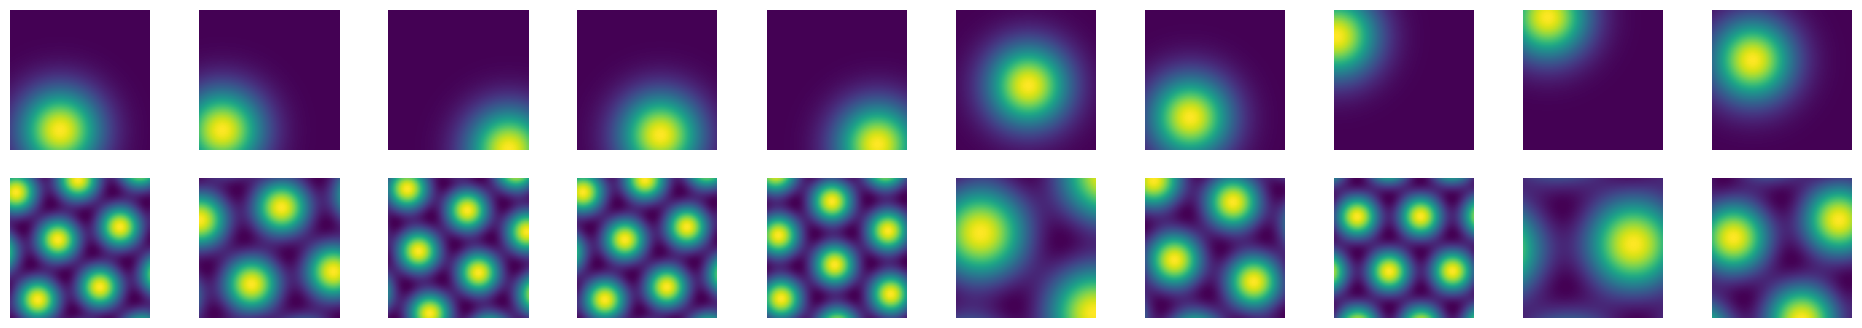

In [5]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [6]:
# Generate a trajectory in the environment
Env = Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = Agent(Env,{'dt':0.1})
for i in range(int(8000/Ag.dt)):
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

# Return place and grid cell activity along trajectory
placeActivity = placeLibrary[:,posidx[:,0],posidx[:,1]]
gridActivity = gridLibrary[:,posidx[:,0],posidx[:,1]]
hpcActivity = np.concatenate((placeActivity,gridActivity),axis=0)

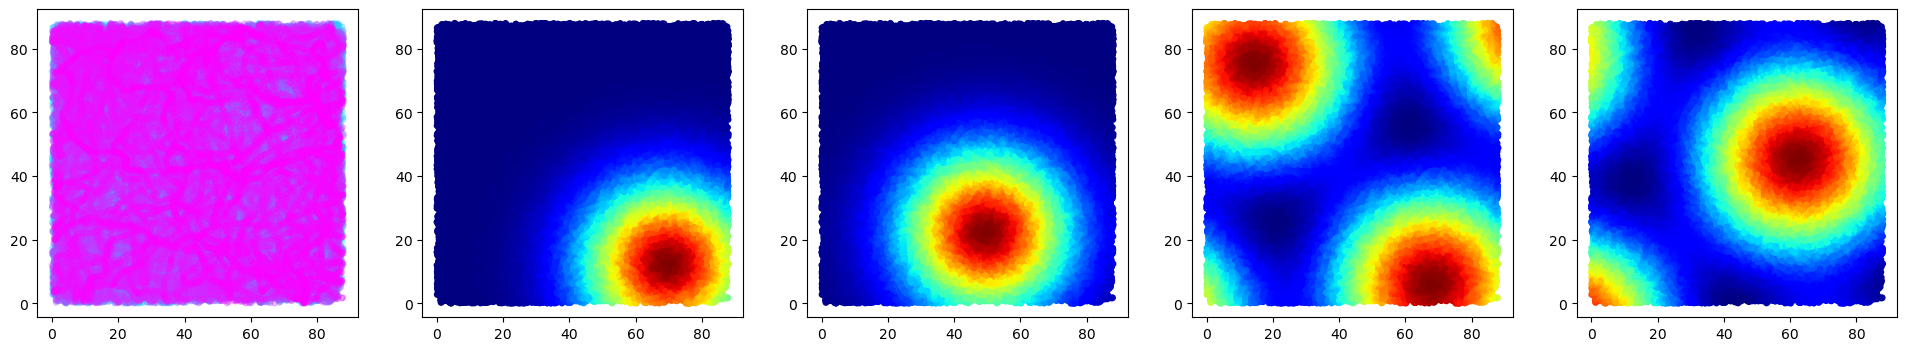

In [7]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
# Ag.plot_trajectory(ax=ax[0])
plt.set_cmap('cool')
ax[0].scatter(pos[:,0],pos[:,1],s=15,c=range(pos.shape[0]),alpha=0.3)
plt.set_cmap('jet')
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=15,c=placeActivity[pexidx[n],:])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=15,c=gridActivity[gexidx[n],:])

## Checkpoint 1:
Now we have simulated hippocampal data, including place fields, grid cells, and a realistic trajectory. 

Next: create random forest PPCA model of the data

In [10]:
# Compute PPCA models of place activity, grid activity, and full hippocampal activity. Used for PCA dimensionality reduction
t = time.time()
lPlace,uPlace,covPlace,nvPlace,wPlace,vPlace = mind.ppca(placeActivity.T)
lGrid,uGrid,covGrid,nvGrid,wGrid,vGrid = mind.ppca(gridActivity.T)
lHPC,uHPC,covHPC,nvHPC,wHPC,vHPC = mind.ppca(hpcActivity.T)
print(f"Numpy finished in {time.time() - t} seconds")
print(f"-- Likelihood for ppca of place activity = {lPlace}, number of components required is {len(wPlace)}")
print(f"-- Likelihood for ppca of grid activity = {lGrid}, number of components required is {len(wGrid)}")
print(f"-- Likelihood for ppca of full HPC model = {lHPC}, and the number of components required for 95% of variance is: {len(wHPC)}")

# Convert activity to PCA scores
pfScores = vPlace.T @ (placeActivity - uPlace.reshape(-1,1))
hpcScores = vHPC.T @ (hpcActivity - uHPC.reshape(-1,1))

Numpy finished in 0.6299989223480225 seconds
-- Likelihood for ppca of place activity = 4347087.091262049, number of components required is 8
-- Likelihood for ppca of grid activity = -4173787.072256823, number of components required is 22
-- Likelihood for ppca of full HPC model = -2787929.212054749, and the number of components required for 95% of variance is: 22


In [11]:
# Construct random forests for place activity and HPC activity (make 100 trees!)
numTrees = 50
nDir = 2
nLeaf = 100
nQuant = 8
placeForest = mind.constructForest(pfScores[:,:-1],pfScores[:,1:],numTrees=numTrees,nDir=nDir,nLeaf=nLeaf,nQuant=nQuant)
hpcForest = mind.constructForest(hpcScores[:,:-1],hpcScores[:,1:],numTrees=numTrees,nDir=nDir,nLeaf=nLeaf,nQuant=nQuant)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
# For adding trees if necessary
trees2add = 0 #95
placeForest = mind.addTrees(pfScores[:,:-1],pfScores[:,1:],placeForest,trees2add)
hpcForest = mind.addTrees(hpcScores[:,:-1],hpcScores[:,1:],hpcForest,trees2add)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
# Summarize Forests (add item with all path structures, add PPCA models to top of forest)
mind.summarizeForest(placeForest)
mind.summarizeForest(hpcForest)

## Checkpoint 2:
Now we have a random forest PPCA model of the data (when I wrote this, I only have it for place activity and full HPC activity). Below, I plot the probability of transitioning to every grid point relative to some chosen starting point (using xC,yC) add plot it, to show that the forest learns which activity patterns are nearby in space to one another. 

In [14]:
# Compute probability of transitions from one point to all other possible points
xp4,yp4 = getBoxCoord(boxLength,4)
xpv = xp4.reshape(-1)
ypv = yp4.reshape(-1)
placeMesh = vPlace.T @ (placeLibrary[:,xpv,ypv] - uPlace.reshape(-1,1))
hpcMesh = vHPC.T @ (np.concatenate((placeLibrary[:,xpv,ypv],gridLibrary[:,xpv,ypv]),axis=0) - uHPC.reshape(-1,1))

xC,yC = 22,22
placeCenter = vPlace.T @ (placeLibrary[:,xC,yC].reshape(-1,1) - uPlace.reshape(-1,1))
hpcCenter = vHPC.T @ (np.concatenate((placeLibrary[:,xC,yC],gridLibrary[:,xC,yC]),axis=0).reshape(-1,1) - uHPC.reshape(-1,1))

In [15]:
placeMeshProb = mind.smartForestLikelihood(np.repeat(placeCenter.reshape(-1,1),placeMesh.shape[1],axis=1), placeMesh, placeForest)
hpcMeshProb = mind.smartForestLikelihood(np.repeat(hpcCenter.reshape(-1,1),hpcMesh.shape[1],axis=1), hpcMesh, hpcForest)

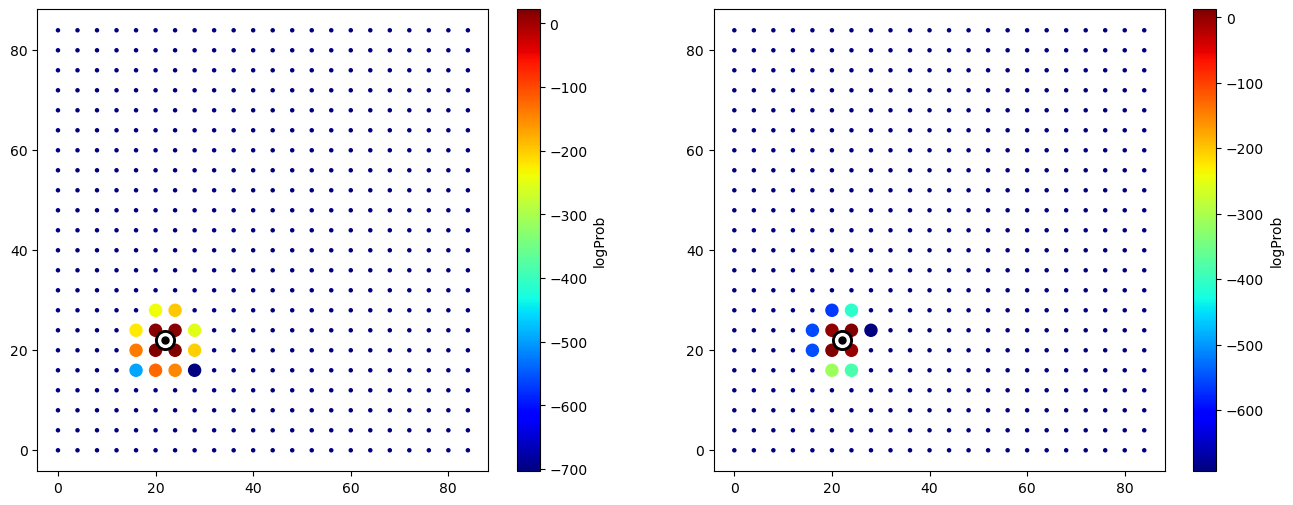

In [16]:
machineEps = np.finfo(float).eps
fig,ax = plt.subplots(1,2,figsize=(16,6))

placeNonzero = np.where(placeMeshProb != 0)[0]
placeZero = np.where(placeMeshProb == 0)[0]
cLimits = (np.min(np.log(placeMeshProb[placeNonzero])), np.max(np.log(placeMeshProb[placeNonzero])))
xx = ax[0].scatter(xpv[placeNonzero],ypv[placeNonzero],s=75,c=np.log(placeMeshProb[placeNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xpv[placeZero],ypv[placeZero],s=5,c=cLimits[0]*np.ones_like(xpv[placeZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xC,yC,s=200,c='k')
ax[0].scatter(xC,yC,s=100,c='w')
ax[0].scatter(xC,yC,s=25,c='k')
plt.colorbar(xx,ax=ax[0],label='logProb')

hpcNonzero = np.where(hpcMeshProb != 0)[0]
hpcZero = np.where(hpcMeshProb == 0)[0]
cLimits = (np.min(np.log(hpcMeshProb[hpcNonzero])), np.max(np.log(hpcMeshProb[hpcNonzero])))
xx = ax[1].scatter(xpv[hpcNonzero],ypv[hpcNonzero],s=75,c=np.log(hpcMeshProb[hpcNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xpv[hpcZero],ypv[hpcZero],s=5,c=cLimits[0]*np.ones_like(xpv[hpcZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xC,yC,s=200,c='k')
ax[1].scatter(xC,yC,s=100,c='w')
ax[1].scatter(xC,yC,s=25,c='k')
plt.colorbar(xx,ax=ax[1],label='logProb')

## Next Step: 
Now, we have to build a distance map across the dataset. As indicated in the biorxiv paper, they do this with "landmark" points, which are selected using a greedy min/max algorithm which starts with random points, then continues selecting each next point as the one furthest away from all others (from this paper: http://graphics.stanford.edu/courses/cs468-05-winter/Papers/Landmarks/Silva_landmarks5.pdf)

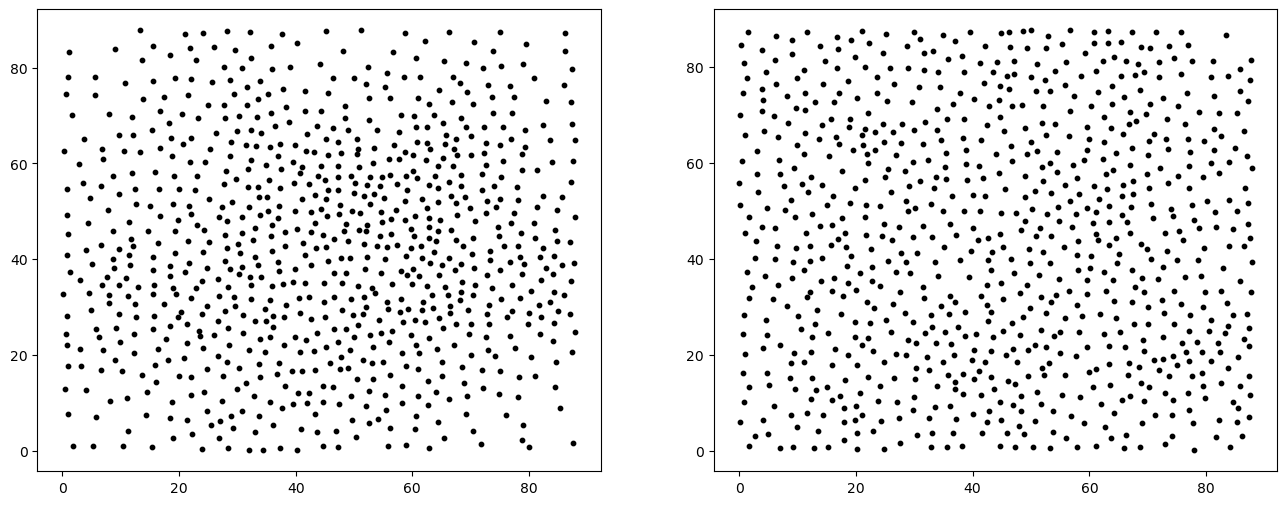

In [17]:
# Return landmark points and compute distance matrix with them
pfLandmark,pfLmIdx = mind.returnLandmarkPoints(pfScores,numLandmark=800,numSeed=1)
hpcLandmark,hpcLmIdx = mind.returnLandmarkPoints(hpcScores,numLandmark=800,numSeed=1)

fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(pos[pfLmIdx,0],pos[pfLmIdx,1],s=10,c='k')
ax[1].scatter(pos[hpcLmIdx,0],pos[hpcLmIdx,1],s=10,c='k');

In [18]:
# Compute pairwise transition probability between all landmark points
pfLmProb = mind.smartGridProbability(pfLandmark, placeForest)
hpcLmProb = mind.smartGridProbability(hpcLandmark, hpcForest)

# Normalize transition probabilities
pfLmProb = pfLmProb / np.sum(pfLmProb,axis=1)
hpcLmProb = hpcLmProb / np.sum(hpcLmProb,axis=1)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
# Convert landmark transition probability into local distance metric 
pfLmLocalDist = mind.probabilityToDistance(pfLmProb)
hpcLmLocalDist = mind.probabilityToDistance(hpcLmProb)

# Convert local distance metric to global geodesic distance using Johnson's algorithm
pfLmGlobalDist = scipy.sparse.csgraph.johnson(pfLmLocalDist)
hpcLmGlobalDist = scipy.sparse.csgraph.johnson(hpcLmLocalDist)

# Symmetrize global distance
pfLmDist = (pfLmGlobalDist + pfLmGlobalDist.T)/2
hpcLmDist = (hpcLmGlobalDist + hpcLmGlobalDist.T)/2

C:\Users\andrew\Documents\modellingData\tank_MIND_simulations\mindAlgorithm1_Freeze.py:379: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-distVector, out=distVector, where=distVector<np.inf)


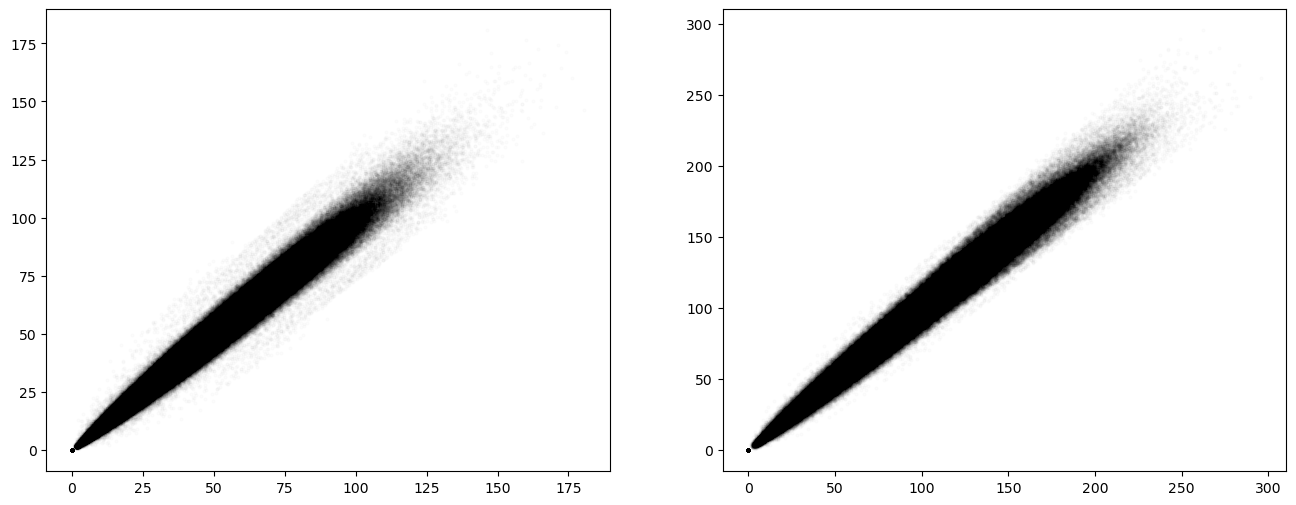

In [20]:
# This shows the comparison between D_ij and D_ji, which should be unity if it's really symmetric dynamics
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(pfLmGlobalDist,pfLmGlobalDist.T,c='k',s=5,alpha=0.01)
ax[1].scatter(hpcLmGlobalDist,hpcLmGlobalDist.T,c='k',s=5,alpha=0.01)

In [19]:
# # Do agglomerative clustering on distance matrices and show sorted heatmaps
# from sklearn.cluster import AgglomerativeClustering
# pfLmCluster = AgglomerativeClustering(n_clusters=50,affinity='precomputed',linkage='average').fit(pfLmDist)
# hpcLmCluster = AgglomerativeClustering(n_clusters=50,affinity='precomputed',linkage='average').fit(hpcLmDist)

# fig,ax = plt.subplots(1,2,figsize=(8,3))
# sortPfDist = pfLmDist[pfLmCluster.labels_,:][:,pfLmCluster.labels_]
# sortHpcDist = hpcLmDist[hpcLmCluster.labels_,:][:,hpcLmCluster.labels_]
# ax[0].imshow(sortPfDist)
# ax[1].imshow(sortHpcDist)

## Checkpoint 3:
Now we have a global distance metric for a subset of landmark points. This is used as a scaffold for the manifold. 

Next, we have to use the distance metric to learn intrinsic manifold coordinates for the landmark points. This uses the conjugate gradient method and corresponds to Sammon mapping. 

In [21]:
# Use classical MDS to get initial estimate of coordinates
numDims = 4
pfCMDS = mind.initMDS(pfLmDist,numDims,method='fast')
hpcCMDS = mind.initMDS(hpcLmDist,numDims,method='fast')

# Use sammon mapping to refine estimate
iterations = pfLmDist.shape[0]
alpha = 0.5
pfSammonUnc,pfError = mind.sammonMapping(pfLmDist, pfCMDS, iterations=iterations, alpha=alpha)
hpcSammonUnc,hpcError = mind.sammonMapping(hpcLmDist, hpcCMDS, iterations=iterations, alpha=alpha)

# Center results using PCA
pfSammon = mind.centerSammonCoordinates(pfSammonUnc)
hpcSammon = mind.centerSammonCoordinates(hpcSammonUnc)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

PF Frobenius (CMDS, Sammon)=[1431.1839194681306, 1143.4442874603926]
PF SammonLoss (CMDS, Sammon)=[1.7223635225024438, 1.0339914513944208]
HPC Frobenius (CMDS, Sammon)=[2360.994561334819, 1923.8563429263074]
HPC SammonLoss (CMDS, Sammon)=[1.3790602319152232, 0.7573451740507491]


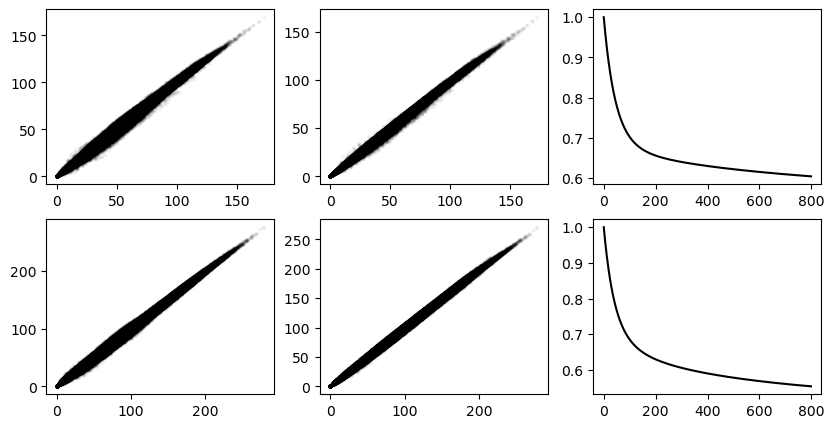

In [22]:
# Compare errors using loss function and frobenius norm
pfDistCMDS = squareform(pdist(pfCMDS))
pfDistSammonUnc = squareform(pdist(pfSammonUnc))
pfDistSammon = squareform(pdist(pfSammon))
hpcDistCMDS = squareform(pdist(hpcCMDS))
hpcDistSammonUnc = squareform(pdist(hpcSammonUnc))
hpcDistSammon = squareform(pdist(hpcSammon))

pfFrobCMDS = np.linalg.norm(pfDistCMDS - pfLmDist)
pfLossCMDS = mind.sammonError(squareform(pfLmDist),squareform(pfDistCMDS)) * 1000
pfFrobSammon = np.linalg.norm(pfDistSammon - pfLmDist)
pfLossSammon = mind.sammonError(squareform(pfLmDist),squareform(pfDistSammon)) * 1000
hpcFrobCMDS = np.linalg.norm(hpcDistCMDS - hpcLmDist)
hpcLossCMDS = mind.sammonError(squareform(hpcLmDist), squareform(hpcDistCMDS)) * 1000
hpcFrobSammon = np.linalg.norm(hpcDistSammon - hpcLmDist)
hpcLossSammon = mind.sammonError(squareform(hpcLmDist), squareform(hpcDistSammon)) * 1000
print(f"PF Frobenius (CMDS, Sammon)={[pfFrobCMDS,pfFrobSammon]}")
print(f"PF SammonLoss (CMDS, Sammon)={[pfLossCMDS,pfLossSammon]}")
print(f"HPC Frobenius (CMDS, Sammon)={[hpcFrobCMDS,hpcFrobSammon]}")
print(f"HPC SammonLoss (CMDS, Sammon)={[hpcLossCMDS,hpcLossSammon]}")

# Comparison of true distance (estimated from landmark points and PPCA forest) and distance from initial MDS estimate
s = 3
alpha = 0.02
fig,ax = plt.subplots(2,3,figsize=(10,5))
ax[0,0].scatter(pfLmDist[:],pfDistCMDS[:],s=s,c='k',alpha=alpha)
ax[0,1].scatter(pfLmDist[:],pfDistSammon[:],s=s,c='k',alpha=alpha)
ax[0,2].plot(range(iterations),pfError/pfError[0],c='k')
ax[1,0].scatter(hpcLmDist[:],hpcDistCMDS[:],s=s,c='k',alpha=alpha)
ax[1,1].scatter(hpcLmDist[:],hpcDistSammon[:],s=s,c='k',alpha=alpha)
ax[1,2].plot(range(iterations),hpcError/hpcError[0],c='k');

In [24]:
idxTest = np.random.choice(pfLandmark.shape[1],100,replace=False)
idxScaf = np.delete(np.arange(pfLandmark.shape[1]),idxTest)

In [310]:
# Optimize forward mapping
NK = 30
NL = 30
plotResults = False
k = np.arange(1,NK+1)
lam = np.logspace(-6,1,NL)
netError = np.zeros((NK,NL))
numTest = 100
idxTest = np.random.choice(pfLandmark.shape[1],numTest,replace=False)
idxScaf = np.delete(np.arange(pfLandmark.shape[1]),idxTest)
for ki,kk in enumerate(k):
    for li,ll in enumerate(lam):
        lmMap = mind.mapping(pfLandmark[:,idxTest].T, pfLandmark[:,idxScaf].T, pfSammon[idxScaf,:], kk, ll)
        netError[ki,li] = np.sqrt(np.sum((pfSammon[idxTest,:] - lmMap)**2))

idxBest = np.unravel_index(np.argmin(netError),netError.shape)
kForward = k[idxBest[0]]
lamForward = lam[idxBest[1]]

if plotResults:
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(6,6))
    axError = ax.imshow(np.log(netError), interpolation='none', extent=[0,NL,NK,0])
    ax.set_xticks(np.arange(NL)[0::3]+0.5,labels=np.round(100000*lam[0::3])/100000)
    ax.set_yticks(np.arange(NK)+0.5,labels=k)
    ax.set_xlabel('Lambda')
    ax.set_ylabel('NumNearestNeighbor')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(axError, cax=cax)

In [311]:
# Optimize reverse mapping
NK = 30
NL = 30
plotResults = False
k = np.arange(1,NK+1)
lam = np.logspace(-5,1,NL)
netError = np.zeros((NK,NL))
numTest = 100
idxTest = np.random.choice(pfLandmark.shape[1],numTest,replace=False)
idxScaf = np.delete(np.arange(pfLandmark.shape[1]),idxTest)
for ki,kk in enumerate(k):
    for li,ll in enumerate(lam):
        lmMap = mind.mapping(pfSammon[idxTest,:], pfSammon[idxScaf,:], pfLandmark[:,idxScaf].T, kk, ll)
        netError[ki,li] = np.sqrt(np.sum((pfLandmark[:,idxTest].T - lmMap)**2))
        
idxBest = np.unravel_index(np.argmin(netError),netError.shape)
kReverse = k[idxBest[0]]
lamReverse = lam[idxBest[1]]

if plotResults:
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(6,6))
    axError = ax.imshow(np.log(netError), interpolation='none', extent=[0,NL,NK,0])
    ax.set_xticks(np.arange(NL)[0::3]+0.5,labels=np.round(100000*lam[0::3])/100000)
    ax.set_yticks(np.arange(NK)+0.5,labels=k)
    ax.set_xlabel('Lambda')
    ax.set_ylabel('NumNearestNeighbor')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(axError, cax=cax)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'HPC Error')

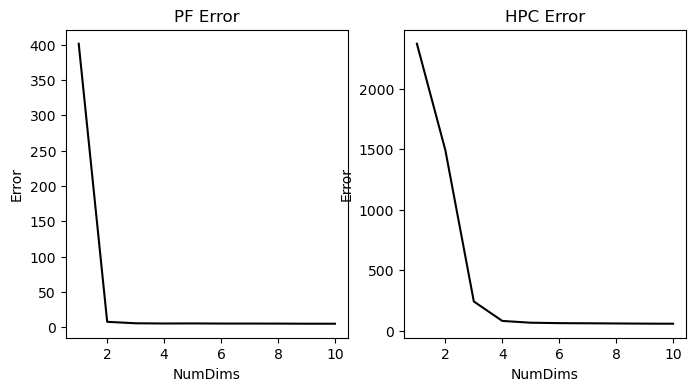

In [328]:
# Run error check to determine optimal number of dimensions!!
pfIdxTest = np.delete(np.arange(pfScores.shape[1]), pfLmIdx)
hpcIdxTest = np.delete(np.arange(hpcScores.shape[1]), hpcLmIdx)

maxDims = 10
dimRec = np.arange(1,maxDims+1)
pfError = np.zeros(len(dimRec))
hpcError = np.zeros(len(dimRec))
for dri, drval in enumerate(dimRec):
    # Start by producing a mapping of the landmark points
    cpfCMDS = mind.initMDS(pfLmDist,drval,method='fast')
    chpcCMDS = mind.initMDS(hpcLmDist,drval,method='fast')
    # Use sammon mapping to refine estimate
    iterations = pfLmDist.shape[0]
    alpha = 0.5
    cpfSammonUnc = mind.sammonMapping(pfLmDist, cpfCMDS, iterations=iterations, alpha=alpha)[0]
    chpcSammonUnc = mind.sammonMapping(hpcLmDist, chpcCMDS, iterations=iterations, alpha=alpha)[0]
    # Center results using PCA
    cpfSammon = mind.centerSammonCoordinates(cpfSammonUnc)
    chpcSammon = mind.centerSammonCoordinates(chpcSammonUnc)
    
    # Then do forward mapping for all non-landmark points
    cPfForwardMap = mind.mapping(pfScores[:,pfIdxTest].T, pfLandmark.T, cpfSammonUnc, kForward, lamForward)
    cHpcForwardMap = mind.mapping(hpcScores[:,hpcIdxTest].T, hpcLandmark.T, chpcSammonUnc, kForward, lamForward)
    # Then do reconstruction (reverse mapping) for all landmark points
    cPfReconstruction = mind.mapping(cPfForwardMap, cpfSammonUnc, pfLandmark.T, kReverse, lamReverse)
    cHpcReconstruction = mind.mapping(cHpcForwardMap, chpcSammonUnc, hpcLandmark.T, kReverse, lamReverse)
    
    # Then compute euclidean error
    pfError[dri] = np.sqrt(np.sum((cPfReconstruction.T - pfScores[:,pfIdxTest])**2))
    hpcError[dri] = np.sqrt(np.sum((cHpcReconstruction.T - hpcScores[:,hpcIdxTest])**2))

Text(0.5, 1.0, 'HPC Error')

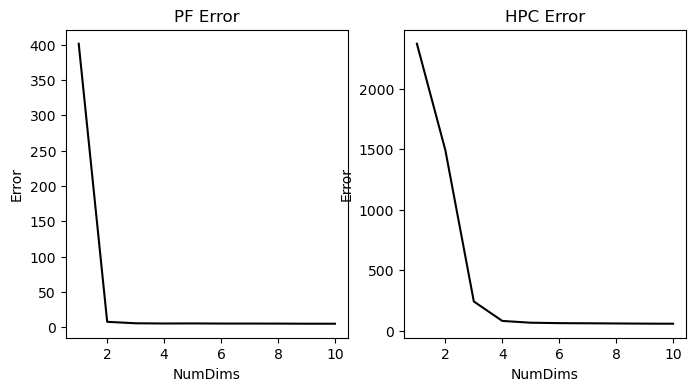

In [329]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(dimRec, pfError, c='k')
ax[0].set_xlabel('NumDims')
ax[0].set_ylabel('Error')
ax[0].set_title('PF Error')
ax[1].plot(dimRec, hpcError, c='k')
ax[1].set_xlabel('NumDims')
ax[1].set_ylabel('Error')
ax[1].set_title('HPC Error')

## Some other code I've used for testing various things 

In [284]:
# Used for testing local functions and a mapping speed up
k = 50
lam = 1
numTest = 400
idxTest = np.random.choice(pfLandmark.shape[1],numTest,replace=False)
idxScaf = np.delete(np.arange(pfLandmark.shape[1]),idxTest)
testPoints = pfLandmark[:,idxTest].T
scafPoints = pfLandmark[:,idxScaf].T
scafTarget = pfSammon[idxScaf,:]
%time lmMapS = mind.mapping(pfLandmark[:,idxTest].T, pfLandmark[:,idxScaf].T, pfSammon[idxScaf,:], k, lam)

CPU times: total: 31.2 ms
Wall time: 18.9 ms


In [162]:
from sklearn.datasets import make_spd_matrix as spd
xx = spd(500)
G = np.linalg.cholesky(xx)
print(f"Determinant: {np.linalg.det(xx)}")
print(f"SmartDet:    {(np.prod(np.diag(G)))**2}")
print(f"WeirdDet:    {np.exp(2*np.sum(np.log(np.diag(G))))}")
print(f"Log Determinant:   {np.log(np.linalg.det(xx))}")
print(f"Log Det Cholesky:  {2*np.log(np.linalg.det(G))}")
print(f"Log Smart Chol:    {2*np.log(np.prod(np.diag(G)))}")
print(f"Log Smarter Chol:  {2*np.sum(np.log(np.diag(G)))}")

Determinant: 2.1204785052493824e-215
SmartDet:    2.1204785150201225e-215
WeirdDet:    2.12047851502009e-215
Log Determinant:   -494.3041532204813
Log Det Cholesky:  -494.3041532158734
Log Smart Chol:    -494.3041532158735
Log Smarter Chol:  -494.3041532158735


In [ ]:
prob = np.random.randint(5, size=4) /4
print(prob)

result = np.where(prob > 0, prob, np.inf)
print(result)
np.log10(result, out=result, where=result > 0)
# -np.log(0)

[0. 1. 1. 1.]
[inf  1.  1.  1.]


array([inf,  0.,  0.,  0.])

In [193]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   hpcActivity: 61.0 MiB
                     hpcScores: 11.6 MiB
                      pfLmProb:  4.9 MiB
                     hpcLmProb:  4.9 MiB
                 pfLmLocalDist:  4.9 MiB
                hpcLmLocalDist:  4.9 MiB
                      pfLmDist:  4.9 MiB
                     hpcLmDist:  4.9 MiB
                    pfDistCMDS:  4.9 MiB
                   hpcDistCMDS:  4.9 MiB


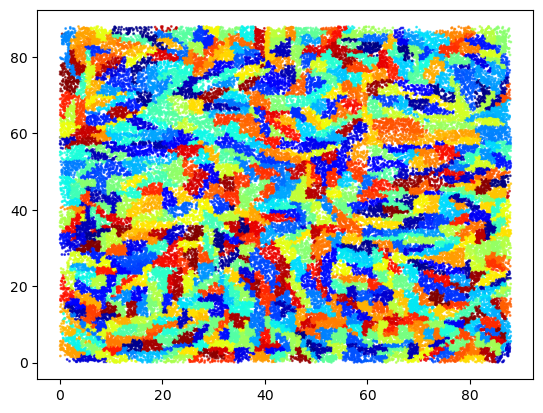

In [196]:
useTreeIdx = 0
pathIndices = mind.returnPathIndexLoop(pfScores,placeForest['tree'][useTreeIdx])
numPaths = len(placeForest['treeSummary'][useTreeIdx])
randIndexDict = dict(zip(np.arange(numPaths),np.random.permutation(numPaths)))
plt.scatter(pos[:,0],pos[:,1],s=1,c=[randIndexDict[pi] for pi in pathIndices],alpha=0.7)

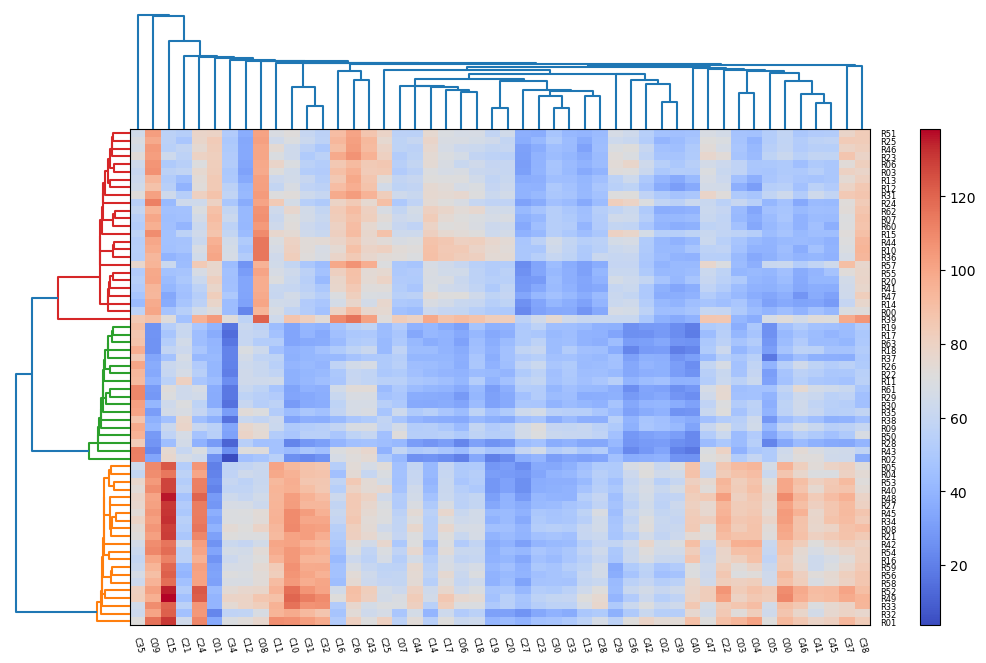

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from heatMapCluster import heatmapcluster


def make_data(size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    s = np.random.gamma([7, 6, 5], [6, 8, 6], size=(size[1], 3)).T
    i = np.random.choice(range(len(s)), size=size[0])
    x = s[i]

    t = np.random.gamma([8, 5, 6], [3, 3, 2.1], size=(size[0], 3)).T
    j = np.random.choice(range(len(t)), size=size[1])

    x += 1.1*t[j].T

    x += 2*np.random.randn(*size)

    row_labels = [('R%02d' % k) for k in range(x.shape[0])]
    col_labels = [('C%02d' % k) for k in range(x.shape[1])]

    return x, row_labels, col_labels


x, row_labels, col_labels = make_data(size=(64, 48), seed=123)

h = heatmapcluster(x, row_labels, col_labels,
                   num_row_clusters=3, num_col_clusters=0,
                   label_fontsize=6,
                   xlabel_rotation=-75,
                   cmap=plt.cm.coolwarm,
                   show_colorbar=True,
                   top_dendrogram=True)
plt.show()

In [115]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [191]:
data = pfScores[:,:10].T
weights = np.ones(data.shape[0])
udata = np.average(data, axis=0, weights=weights)
cdata = data - udata



In [192]:
data = pfScores[:,:10].T
weights = np.maximum(np.random.normal(0,0.2,(data.shape[0]))+1,0.1) #np.ones(data.shape[0])
udata = np.average(data, axis=0, weights=weights)
cdata = data - udata

torchData = torch.tensor(cdata, device=device).float().T; 
torchWeights = torch.tensor(weights, device=device).float();

%time wcovData = (1/np.sum(weights)) * (cdata.T @ np.diag(weights) @ cdata)
%time rcovData = np.cov(cdata.T, bias=True, aweights=weights)
%time tcovData = torch.cov(torchData,correction=0,aweights=torchWeights)

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 15.6 ms
Wall time: 997 µs


In [190]:
torch.allclose(torch.tensor(wcovData,device=device).float(),tcovData)

True

In [207]:
xxx = np.arange(5).reshape(-1,1) + np.arange(5).reshape(1,-1)
xxx = xxx - np.diag(np.diag(xxx))
print(xxx)
print(squareform(xxx))

[[0 1 2 3 4]
 [1 0 3 4 5]
 [2 3 0 5 6]
 [3 4 5 0 7]
 [4 5 6 7 0]]
[1 2 3 4 3 4 5 5 6 7]


In [134]:
nb.__version__

'0.55.1'

In [135]:
np.__version__

'1.21.5'

In [98]:
u.T.shape

(6, 800)

In [107]:
import numba as nb
import numpy as np

def fastGrid(data, u, iS, logDet, D): 
    N = data.shape[1] 
    probability = np.zeros((N,N))
    for n in range(N):
        udata = data - u[:,n].reshape(-1,1)
        cexparg = np.sum((iS[:,:,n] @ udata) * udata,axis=0)
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n,:] = np.exp(cloglikelihood)
    return probability

def mindGrid(data,u,iS,logDet,D):
    N = data.shape[1]
    probability = np.zeros((N,N))
    for n in range(N):
        cudata = data - u[:,n].reshape(D,1)
        cexparg = (-1/2) * np.sum((iS[:,:,n] @ cudata) * cudata, axis=0)
        cloglik = -D/2*np.log(2*np.pi) - 1/2*logDet[n] + cexparg
        probability[n,:] = np.exp(cloglik)
    return probability

@nb.njit(nb.float64[:,::1](nb.float64[:,::1],nb.float64[:,::1],nb.float64[:,:,::1],nb.float64[::1],nb.float64), nogil=True, parallel=True)
def fastGridNC(data, u, iS, logDet, D): 
    N = data.shape[0] 
    probability = np.zeros((N,N))
    for n in nb.prange(N):
        udata = np.zeros_like(data)
        # subtract mean
        for n1 in range(N):
            udata[n1,:] = data[n1,:] - u[n,:]
        cexpargmat = (udata @ iS[n]) * udata
        cexparg = np.zeros_like(logDet)
        for n1 in range(N):
            cexparg[n1] = np.sum(cexpargmat[n1,:])
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n,:] = np.exp(cloglikelihood)
    return probability

@nb.njit(nb.float64[:,::1](nb.float64[:,::1],nb.float64[:,::1],nb.float64[:,:,::1],nb.float64[::1],nb.float64), nogil=True, parallel=True)
def difGridNC(data, u, iS, logDet, D): 
    N = data.shape[0] 
    probability = np.zeros((N,N))
    for n in nb.prange(N):
        udata = np.zeros_like(data)
        # subtract mean
        for n1 in range(N):
            udata[n1] = data[n1] - u[n]
        cexpargmat = (udata @ iS[n]) * udata
        cexparg = np.zeros_like(logDet)
        for n1 in range(N):
            cexparg[n1] = np.sum(cexpargmat[n1])
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n] = np.exp(cloglikelihood)
    return probability

tt = 0
T = 5
data = pfLandmark
D,N = data.shape
v0 = np.zeros((N,N,T))
v1 = np.zeros((N,N,T))
v2 = np.zeros((N,N,T))
# for tt in range(T):
tt=0
tPathIdx = mind.returnPathIndexLoop(data, placeForest['tree'][tt])
u = placeForest['ppcaMeans'][tt][tPathIdx,:]
iS = placeForest['ppcaInvCovs'][tt][tPathIdx,:,:]
logDet = placeForest['ppcaLogDets'][tt][tPathIdx]

tdata = np.ascontiguousarray(data.T)
tu = u
tiS = iS
tLogDet = logDet

# v0[:,:,tt] = fastGrid(data,u.T,iS.transpose(1,2,0),logDet,D)
# v1[:,:,tt] = mindGrid(data,u.T,iS.transpose(1,2,0),logDet,D)
# v2[:,:,tt] = fastGridNC(tdata,tu,tiS,tlogDet,D)

# xxx = mind.smartGridProbability(pfLandmark, placeForest)
# yyy = mind.numbaGridProbability(pfLandmark, placeForest)
# %timeit v0 = fastGrid(data,u,iS,logDet,D)
%timeit v1 = difGridNC(tdata,tu,tiS,tLogDet,D)
%timeit v2 = fastGridNC(tdata,tu,tiS,tLogDet,D)

print(np.allclose(v0,v1))
print(np.allclose(v0,v2))
print(np.allclose(v1,v2))
print(np.allclose(xxx,yyy))

59.7 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.48 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
True
True
True


In [42]:
len(placeForest['tree'])

5

In [23]:
import numpy as np 
N,D = 100,7
data = np.random.normal(0,1,(D,N))
u = np.random.normal(0,1,(D,N))
iS = np.random.normal(0,1,(D,D,N))
logDet = np.random.normal(10,1,N)

udata = np.random.normal(0,1,(D,N,N))
mexp = np.zeros((N,N))
for n1 in range(N):
    for n2 in range(N):
        mexp[n1,n2] = udata[:,n1,n2] @ iS[:,:,n2] @ udata[:,n1,n2]
einexp = np.einsum('dnm,ddm,dnm -> nm',udata, iS, udata) 

ein1 = np.einsum('ddm,dnm -> dnm', iS, udata)
ein2 = np.einsum('dnm,dnm -> nm', udata, ein1)
print(mexp.shape)
print(einexp.shape)
print(np.allclose(mexp,einexp.T))
print(np.allclose(mexp,ein2))

(100, 100)
(100, 100)
False
False
